# Adaptive layer size

In this tutorial we show the learning of the size of a layer on a simple one dimensional regression dataset. 

In [1]:
import sys

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import scipy.stats as sp_stats
import torch
from torch import nn
from torch import optim
import tqdm.notebook as tqdm

In [2]:
sys.path.append("../")

from bal import layers
import utils

## Dataset

We generate a dataset of labeled real valued features $\left\{(x, y)_i\right\}_{i=1..N}$ from: 
$$
x \sim Uni(-2, 2) \\
y = \mathrm{sin}(6x) + 0.4x^2 - 0.1x^3 - x\mathrm{cos}\left(9\sqrt{e^x}\right) + \epsilon \hspace{1cm} \textrm{where}\hspace{0.2cm} \epsilon \sim \mathcal{N}(0, 0.1)
$$

This dataset generating function could be approximated well by a sum of piece-wise linear functions, e.g. the output of the hidden layer after a ReLU non-linearity.

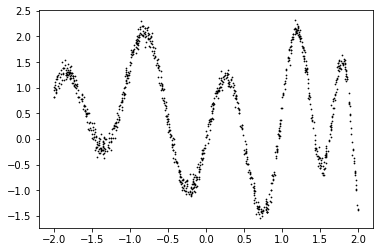

In [3]:
domain = (-2.0, 2.0)
noise_std = 0.1

xs, ys = utils.generate_1d_regression(
    n_points=1000,
    domain=domain, 
    noise_std=0.1, 
    seed=7
)

plt.scatter(xs.ravel(), ys.ravel(), s=0.5, c='black' )
plt.show()

# We also define a test set which goes beyond the limits in the training set
# and convert the numpy arrays to torch.Tensor types
xs_test = np.linspace(-4.0, 4.0, 200).reshape(-1, 1)
xs_test_t = torch.as_tensor(xs_test, dtype=torch.float32)
xs_t = torch.as_tensor(xs, dtype=torch.float32)
ys_t = torch.as_tensor(ys, dtype=torch.float32)

## Layer size growth

For illustrative purposes, we create a network with only one hidden layer. Our belief of the optimal layer size is encoded in the prior, which we will set very conseravitively to 1 unit. This is obviously insufficient to fit the data good enough and the network will have to allocate more units. Thus we expect that the variational parameter for the layer size $\mu$ increases steadily until the fit becomes nearly perfect. On the other hand, the standard deviation of the truncated normal $\sigma$ may increase in the beginning and shrink later on. We interpret this parameter as the epistemic uncertainty of the layer size.

In [4]:
class AdaptiveNet(nn.Module):
    def __init__(self, 
                 in_features, 
                 h_size, 
                 out_features, 
                 prior_loc, 
                 prior_scale,
                 likelihood_noise_std):
        super(AdaptiveNet, self).__init__()
        self.fc1 = nn.Linear(in_features, h_size)
        self.ada1 = layers.AdaptiveSize(
            min_size=1,
            max_size=h_size,
            prior_loc=prior_loc,
            prior_scale=prior_scale,
            temperature=1.0
        )
        self.fc2 = nn.Linear(h_size, out_features)
        self.lik = layers.GaussianLikelihood(scale=likelihood_noise_std)
        self.bayesian_layers = [self.ada1]

    def forward(self, inp):
        out = nn.functional.relu(self.fc1(inp))
        out = self.ada1(out)
        out = self.fc2(out)
        return out

    def log_likelihood(self, xs, ys):
        params = self.forward(xs)
        logprobs = self.lik(params).log_prob(ys)
        return logprobs
    
    def kl_qp(self, n_samples=1, scale=1.0):
        kls = []
        for bl in self.bayesian_layers:
            kls.append(bl.kl_posterior_prior(n_samples))
        return scale * torch.sum(torch.stack(kls))

We define the body of the optimisation loop in the following function. Here the gradient buffers are cleared, the loss, the corresponding gradients and the metrics computed. The network weights and the variational parameters are then updated.

In [5]:
def run_step(xs_t, ys_t, opt, net, kl_scale=1.0):
    opt.zero_grad()
    ll = torch.mean(net.log_likelihood(xs_t, ys_t))
    kl = net.kl_qp(n_samples=1, scale=kl_scale)
    loss = kl - ll
    loss.backward()
    opt.step()
    stats = {
        "loss": float(loss.detach().numpy()),
        "layer_loc": float(net.ada1.var_loc.detach().numpy()),
        "layer_scale": float(nn.functional.softplus(net.ada1.var_spi_scale.detach()).numpy())
    }
    return stats

Note that if we do batched optimisation of the negative ELBO, we have to scale down the contribution of the KL-term so that the sum accorss the batches amounts to the total KL for one epoch. One way to do this is to scale it with a geometrically progressing factor, as suggested by [Blundell et. al, 2015](https://arxiv.org/pdf/1505.05424.pdf).

In [6]:
def geometric_discount(n, i):
    return 2 ** (n - i) / (2 ** n - 1)

In [7]:
MAX_SIZE = 50
PRIOR_LOC = 1
PRIOR_SCALE = 3

net = AdaptiveNet(
    in_features=1,
    h_size=MAX_SIZE,
    out_features=1,
    prior_loc=PRIOR_LOC,
    prior_scale=PRIOR_SCALE,
    likelihood_noise_std=noise_std
)

opt = optim.Adam(net.parameters(), lr=3e-3)

In [8]:
N_EPOCHS = 30000
BATCH_SIZE = 500

pbar = tqdm.tqdm(range(N_EPOCHS))
train_history = {"layer_loc": [], "layer_scale": [], "preds": []}
for i in pbar:
    for j, (x_t, y_t) in enumerate(utils.batch_generator(xs_t, ys_t, BATCH_SIZE, shuffle=True)):
        kl_scale = geometric_discount(len(xs_t) // BATCH_SIZE, j+1)
        stats = run_step(x_t, y_t, opt, net, kl_scale)
    if i % 300 == 0:
        pbar.set_description_str(
            f"loss: {stats['loss']:4.2f}, " 
            f"l_loc: {stats['layer_loc']:4.2f}, " 
            f"l_scale: {stats['layer_scale']:4.2f}"
        )
        train_history["layer_loc"].append(stats["layer_loc"])
        train_history["layer_scale"].append(stats["layer_scale"])
        train_history["preds"].append(net(xs_test_t).detach().numpy().squeeze())

for k, v in train_history.items():
    train_history[k] = np.asarray(v)

We now plot the coupling truncated normal distirbution of the layer size over time. In the leftmost image we see the current data fit, the middle one shows the density of the truncated normal at each time step and the rightmost one depicts an overview of the changing density over time.

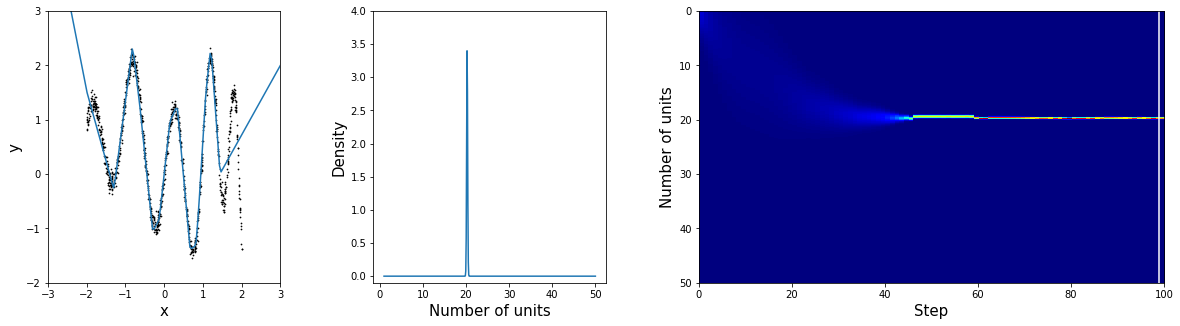

In [9]:
ani = utils.animate_adaptive_layer(
    data=(xs, ys), 
    predictions=(xs_test, train_history["preds"]), 
    layer_stats=(train_history["layer_loc"], train_history["layer_scale"]), 
    max_size=MAX_SIZE, 
    output_path="../layer_size_growing.mp4"
)
HTML(ani.to_html5_video())